### Brief description of the problem and data (5 pts) 

* **Problem**: This is a binary image classification problem. We need to detect presence of metastases from 96*96px hispopathology images. 
* **Data**: We have 220k training images and 57k validation images/. Data is subset of PCAM dataset, they removed duplicate images. Images are 96*96px and we are trying to predict a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

### Exploratory Data Analysis (EDA) 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import pathlib
import os
import cv2
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
%matplotlib inline

### Data Wrangling

In [2]:
print(f'{len(os.listdir("/kaggle/input/histopathologic-cancer-detection/train"))} pictures in train.')
print(f'{len(os.listdir("/kaggle/input/histopathologic-cancer-detection/test"))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


In [3]:
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

#### Label balance

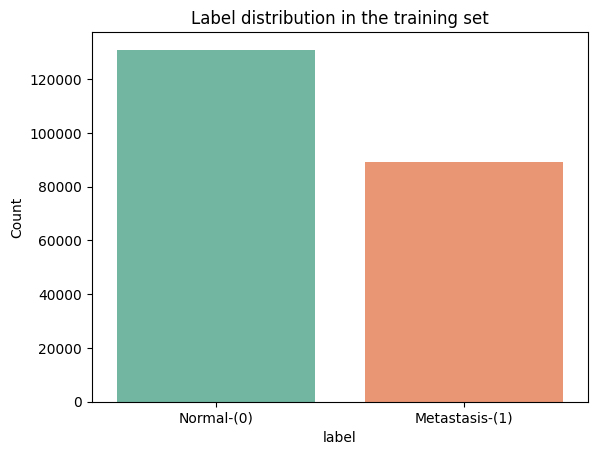

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


In [4]:
sns.countplot(x='label', data=labels, palette='Set2')
plt.title('Label distribution in the training set')
plt.xticks([0,1], ['Normal-(0)', 'Metastasis-(1)'])
plt.ylabel('Count'); plt.show()

print(labels['label'].value_counts(normalize=True).rename('proportion'))

* We can almost 60% percent of our dataset is normal, and 40% of them has Metastasis. Data slightly inblanaced.

In [6]:
train_dir = pathlib.Path('/kaggle/input/histopathologic-cancer-detection/train')
broken = []
for fname in tqdm(labels['id'].head(5000)):         
    f = train_dir / f'{fname}.tif'
    try:
        im = Image.open(f)
        if im.size != (96,96): broken.append(fname)
    except UnidentifiedImageError:
        broken.append(fname)
print(f'Broken or wrong-size files: {len(broken)}')

100%|██████████| 5000/5000 [00:30<00:00, 165.20it/s]

Broken or wrong-size files: 0


* Here I checked pixel size of the portion of the train dataset, and it passed the test, data is clean sizes are correct.

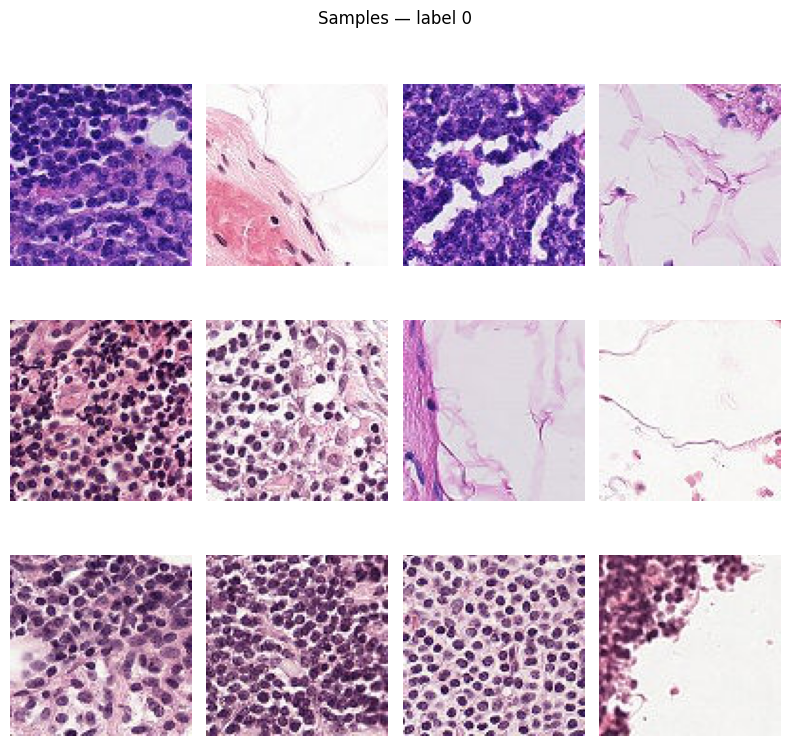

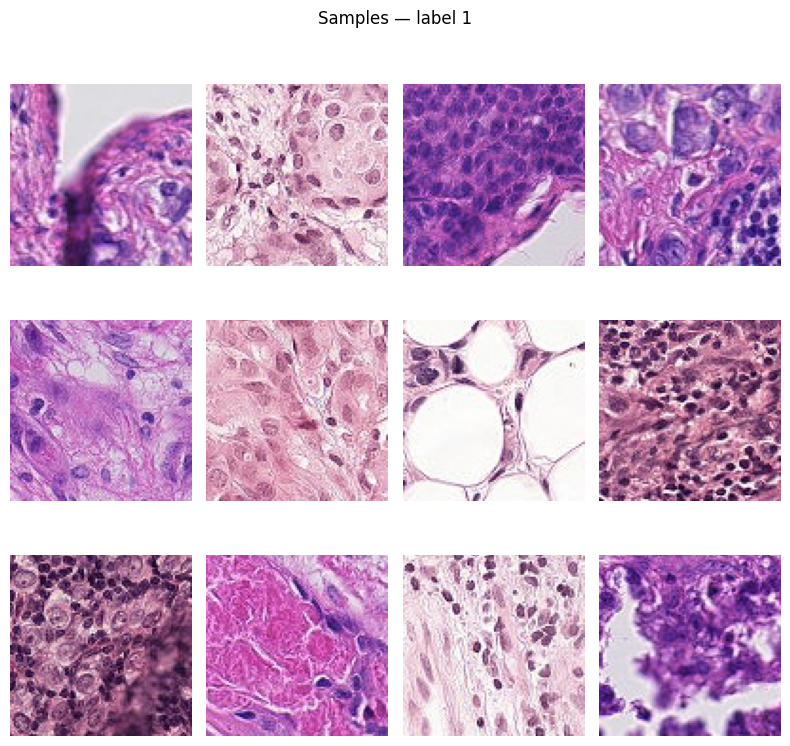

In [7]:
def show_grid(df, label, n=12):
    subset = df[df.label==label].sample(n)
    plt.figure(figsize=(8,8))
    for i, row in enumerate(subset.itertuples(), 1):
        img = Image.open(train_dir/f'{row.id}.tif')
        plt.subplot(3,4,i); plt.imshow(img); plt.axis('off')
    plt.suptitle(f'Samples — label {label}')
    plt.tight_layout(); plt.show()

show_grid(labels, 0); show_grid(labels, 1)


* Well I actually couldnt find the cancer with bare eyes, it supposed be in the center of image. 

## DModel Architecture (25 pts)

### Configuration

In [15]:
from tensorflow.keras.optimizers import Adam, RMSprop

In [6]:
port tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
AUTOTUNE = tf.data.AUTOTUNE
BATCH  = 64
IMG_SIZE = 96
EPOCHS = 10
LEARNING_RATE = 0.001
print("GPU available:", tf.config.list_physical_devices('GPU'))
TRAIN_DIR = pathlib.Path('/kaggle/input/histopathologic-cancer-detection/train')
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
labels = labels.sample(frac=0.5)  
labels['filename'] = labels['id'] + '.tif'
labels['label']    = labels['label'].astype(str) 

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [7]:
train_df, val_df = train_test_split(labels, test_size=0.10, stratify=labels['label'])

## PREPROCESSING

In [8]:
# We have enough data I am not going to increase the sizes. 
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)
val_datagen = ImageDataGenerator(rescale=1/255.)

In [10]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(TRAIN_DIR),
    x_col='filename',
    y_col='label',
    classes=['0','1'],
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary',
    shuffle=True         
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(TRAIN_DIR),
    x_col='filename',
    y_col='label',
    classes=['0','1'],
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary',
    shuffle=False
)


print('train batches per epoch :', len(train_gen))
print('validation batches :', len(val_gen))

Found 99010 validated image filenames belonging to 2 classes.
Found 11002 validated image filenames belonging to 2 classes.
train batches per epoch : 1548
validation batches : 172


## MODEL ARCHITECTURES

In [11]:
def create_simple_cnn():
    
    model = tf.keras.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPool2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPool2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_enhanced_cnn():
  
    model = Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        
        
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.25),
        
        
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.25),
        
        
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_resnet_model():
    
    base = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base.trainable = False 
    
    model = Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    mode='max'
)

## MODEL TRAINING AND COMPARISON

In [38]:
results = {}

### TRAINING SIMPLE CNN

In [ ]:
simple_model = create_simple_cnn()
simple_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

simple_model.summary()

history_simple = simple_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

results['Simple CNN'] = history_simple

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)                   │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 496s 318ms/step - accuracy: 0.7433 - auc: 0.8095 - loss: 0.5149 - val_accuracy: 0.7718 - val_auc: 0.8729 - val_loss: 0.5110 - learning_rate: 0.0010
Epoch 2/10
 474/1548 ━━━━━━━━━━━━━━━━━━━━ 4:51 272ms/step - accuracy: 0.7950 - auc: 0.8637 - loss: 0.4484

### TRAINING ENHANCED CNN

In [ ]:
enhanced_model = create_enhanced_cnn()
enhanced_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

enhanced_model.summary()

history_enhanced = enhanced_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

results['Enhanced CNN'] = history_enhanced

### TRAINING RESNET50 (TRANSFER LEARNING)

In [ ]:
resnet_model = create_resnet_model()
resnet_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

resnet_model.summary()

history_resnet = resnet_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

results['ResNet50'] = history_resnet


### INITIAL MODEL PERFORMANCE COMPARISON

In [ ]:
initial_results = []
for model_name, history in results.items():
    final_train_auc = history.history['auc'][-1]
    final_val_auc = max(history.history['val_auc'])
    final_train_acc = history.history['accuracy'][-1] if 'accuracy' in history.history else 0
    final_val_acc = max(history.history['val_accuracy']) if 'val_accuracy' in history.history else 0
    
    initial_results .append({
        'Model': model_name,
        'Final Train AUC': f"{final_train_auc:.4f}",
        'Best Val AUC': f"{final_val_auc:.4f}",
        'Final Train Acc': f"{final_train_acc:.4f}",
        'Best Val Acc': f"{final_val_acc:.4f}",
        'Epochs Trained': len(history.history['auc'])
    })

initial_results_df = pd.DataFrame(initial_results)
print(initial_results_df.to_string(index=False))

In [44]:
### Identifying best model
best_initial_model = max(results.keys(), 
                        key=lambda x: max(results[x].history['val_auc']))
best_initial_auc = max(results[best_initial_model].history['val_auc'])
print(f" best initial model: {best_initial_model}")
print(f"best val AUC: {best_initial_auc:.4f}")

 best initial model: Enhanced CNN
best val AUC: 0.9705


In [ ]:
def plot_initial_models(results):
    """plot comparing the 3 initial models"""
    plt.figure(figsize=(15, 5))
    
    #plot1
    plt.subplot(1, 3, 1)
    for model_name, history in results.items():
        plt.plot(history.history['val_auc'], label=model_name, linewidth=2)
    plt.title('Val AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
    
    #plot2 for final comparision
    plt.subplot(1, 3, 2)
    model_names = list(results.keys())
    final_aucs = [max(hist.history['val_auc']) for hist in results.values()]
    colors = ['blue', 'red', 'green']
    plt.bar(model_names, final_aucs, color=colors, alpha=0.7)
    plt.title('Best Validation AUC')
    plt.ylabel('AUC Score')
    plt.ylim(0.85, 1.0)
    plt.xticks(rotation=45)
    
    #plot3 train vs valid AUC
    plt.subplot(1, 3, 3)
    train_aucs = [hist.history['auc'][-1] for hist in results.values()]
    val_aucs = [max(hist.history['val_auc']) for hist in results.values()]
    
    x = range(len(model_names))
    plt.bar([i-0.2 for i in x], train_aucs, width=0.4, label='Train AUC', alpha=0.7)
    plt.bar([i+0.2 for i in x], val_aucs, width=0.4, label='Val AUC', alpha=0.7)
    plt.title('Train vs Val AUC')
    plt.ylabel('AUC')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

**Model Performance Summary**
I trained three different models for 10 epochs each: a simple CNN, an enhanced CNN with added layers and regularization, and a ResNet50-based transfer learning model. After evaluating each model on both the training and validation sets, I compared their AUC metrics.

The enhanced CNN consistently outperformed the others. It achieved the highest validation AUC, showing both strong generalization. The simple CNN performed reasonably well, but not as strongly. Suprasingly the ResNet50 model underperformed compared to both CNNs.

**Why did ResNet50 fail?**
* Medical histopathology images are very different from ImageNet's natural images
* Pre-trained features (animals, objects, scenes) don't transfer well to medical images, I should have only frezee low level layers which can be transfered more easily. this shows the importance of domain-specific features in medical imaging


### HYPERPARAMETER TUNING EXPERIMENT

In [12]:
### testing different learning rates I used this before (0.001)
learning_rates = [0.01, 0.0001]
hyperparameter_results = {}

for lr in learning_rates:
    print(f"learning rate: {lr}")
    
    tuning_model = create_enhanced_cnn()
    tuning_model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
    )
    
    
    history_tune = tuning_model.fit(
        train_gen,
        epochs=8,
        validation_data=val_gen,
        callbacks=[EarlyStopping(monitor='val_auc', patience=3, mode='max')],
        verbose=0
    )
    
    hyperparameter_results[f'LR_{lr}'] = history_tune
    final_auc = max(history_tune.history['val_auc'])
    print(f"best val AUC with learning rate {lr}: {final_auc:.4f}")


learning rate: 0.01


I0000 00:00:1748955215.248698      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748955215.249442      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748955225.503354     100 service.cc:148] XLA service 0x792434048100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:17489

best val AUC with learning rate 0.01: 0.9571
learning rate: 0.0001
best val AUC with learning rate 0.0001: 0.9225


In [20]:
# testing different optimizers
optimizer_results = {}


optimizers_config = {
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adam': Adam(learning_rate=0.001)
}
for opt_name, optimizer in optimizers_config.items():
    print(f"optimizer: {opt_name}")
    
    tuning_model = create_enhanced_cnn()
    tuning_model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
    )
    
    history_tune = tuning_model.fit(
        train_gen,
        epochs=8,
        validation_data=val_gen,
        callbacks=[EarlyStopping(monitor='val_auc', patience=3, mode='max')],
        verbose=0
    )
    
    optimizer_results[f'{opt_name}'] = history_tune
    best_auc = max(history_tune.history['val_auc'])
    print(f"best Val AUC: {best_auc:.4f}")
    
    # Save the model for this optimizer
    tuning_model.save(f'enhanced_cnn_{opt_name.lower()}.h5')
    print(f"model with {opt_name} saved!")

optimizer: RMSprop
best Val AUC: 0.9631
model with RMSprop saved!
optimizer: Adam
best Val AUC: 0.9529
model with Adam saved!


In [23]:
def plot_hyperparameter_results(hp_results):
    
    plt.figure(figsize=(12, 4))
    
    # plot1
    plt.subplot(1, 2, 1)
    for exp_name, history in hp_results.items():
        lr = exp_name.split('_')[1]
        plt.plot(history.history['val_auc'], label=f'LR = {lr}', linewidth=2)
    plt.title('Hyperparameter Tuning: Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Validation AUC')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Best AUC comparison
    plt.subplot(1, 2, 2)
    learning_rates = [exp.split('_')[1] for exp in hp_results.keys()]
    best_aucs = [max(hist.history['val_auc']) for hist in hp_results.values()]
    plt.bar(learning_rates, best_aucs, color='orange', alpha=0.7)
    plt.title('Best AUC by Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Best Validation AUC')
    plt.ylim(0.85, 1.0)
    
    plt.tight_layout()
    plt.show()

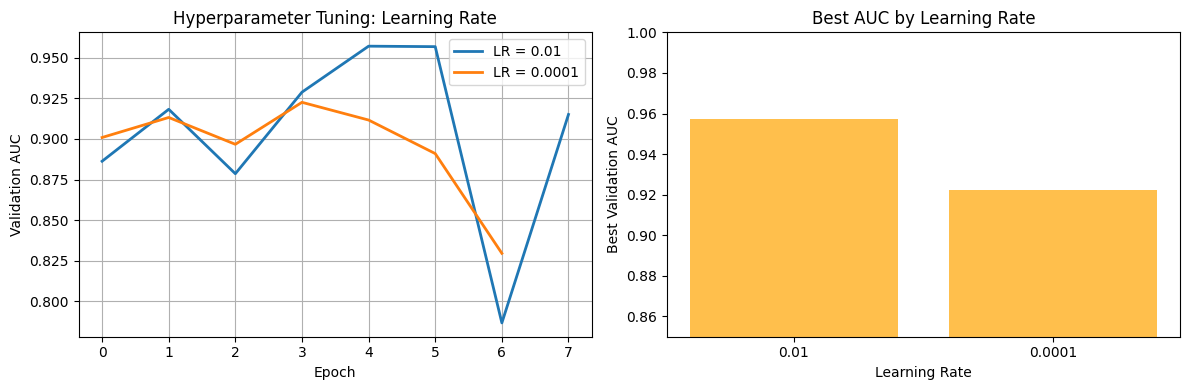

In [24]:
plot_hyperparameter_results(hyperparameter_results)